# Работа с временными рядами

Отличная статья про временные ряды от Дмитрия Сергеева - https://habr.com/company/ods/blog/327242/. 

**Временной ряд** - последовательно измеренные через некоторые (зачастую равные) промежутки времени данные.

Обычно в задачах анализа данных предполагается независимость наблюдений. При работе с временными рядами мы строим свой прогноз на основе наблюдений из прошлого.

Компоненты временного ряда:
- Тренд - систематическая линейная или нелинейная компонента, изменяющаяся во времени.
- Сезонность - периодические колебания уровней временного ряда внутри года (например).
- Цикл - периодические колебания, как правило, больше, чем один сезоннный период, не имеют определенной продолжительности.
- Ошибка - непрогнозируемая компонента.
- Уровень - среднее значение временного ряда.


<img width = '800px' src="images/lesson_10/tss.png">

In [1]:
!pip install statsmodels

In [2]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams
import warnings
from pandas.core.nanops import nanmean as pd_nanmean

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')
%matplotlib inline

Датасет ежечасного потребления электроэнергии за последние 10 лет американской компании AEP в мегаваттах.

https://www.kaggle.com/robikscube/hourly-energy-consumption#AEP_hourly.csv

In [3]:
energy_consumption = pd.read_csv('files/lesson_10/AEP_hourly.csv', sep =',')
energy_consumption.head(2)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0


In [4]:
energy_consumption.info

<bound method DataFrame.info of                    Datetime   AEP_MW
0       2004-12-31 01:00:00  13478.0
1       2004-12-31 02:00:00  12865.0
2       2004-12-31 03:00:00  12577.0
3       2004-12-31 04:00:00  12517.0
4       2004-12-31 05:00:00  12670.0
...                     ...      ...
121268  2018-01-01 20:00:00  21089.0
121269  2018-01-01 21:00:00  20999.0
121270  2018-01-01 22:00:00  20820.0
121271  2018-01-01 23:00:00  20415.0
121272  2018-01-02 00:00:00  19993.0

[121273 rows x 2 columns]>

In [5]:
energy_consumption.sort_values('Datetime',axis = 0,inplace =True)
energy_consumption = energy_consumption.iloc[-30000:]
energy_consumption['Datetime'] = pd.to_datetime(energy_consumption.Datetime,format='%Y-%m-%d %H:%M:%S') 
energy_consumption.index  = energy_consumption.Datetime
energy_consumption.drop('Datetime', axis = 1, inplace = True)
energy_consumption.head(2)

,AEP_MW
Datetime,
2015-03-02 00:00:00,15867.0
2015-03-02 01:00:00,15444.0


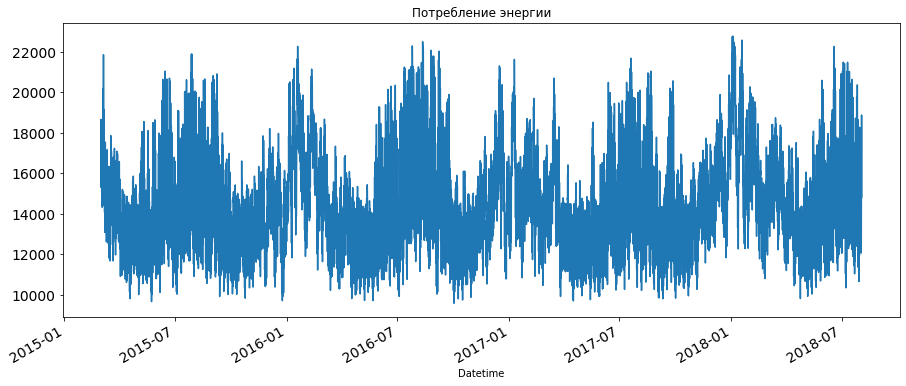

In [6]:
energy_consumption.AEP_MW.plot( figsize=(15,6),title= 'Потребление энергии', fontsize=14)

### **Компоненты временного ряда**

Наш временной ряд раскладывается на отдельные компоненты, работая по отдельности с каждой из них будет проще строить прогноз. 

$Y_t = f(Trend, Seasonality,Cycle,Reminder) $

<img width = '500px' src="images/lesson_10/paintings.jpg">

Отдельные компоненты временного ряда очень похожи на краски, которые смешиваются и получается определенный цвет (наш исходный временной ряд).

#### 1. Сезонность

In [7]:
rcParams['figure.figsize'] = 20, 5
energy_consumption['year'] = energy_consumption.index.year
energy_consumption['month'] = energy_consumption.index.month
energy_consumption['hour'] = energy_consumption.index.hour
energy_consumption['dow'] = energy_consumption.index.dayofweek
energy_consumption_pivot = pd.pivot_table(energy_consumption, values = "AEP_MW", columns = "year", index = "month")
energy_consumption.head(2)

,AEP_MW,year,month,hour,dow
Datetime,,,,,
2015-03-02 00:00:00,15867.0,2015,3,0,0
2015-03-02 01:00:00,15444.0,2015,3,1,0


In [8]:
energy_consumption_pivot.head(2)

year,2015,2016,2017,2018
month,,,,
1,NaN,16760.747312,15566.197581,17594.87500
2,NaN,15895.386494,14665.684524,15276.66369


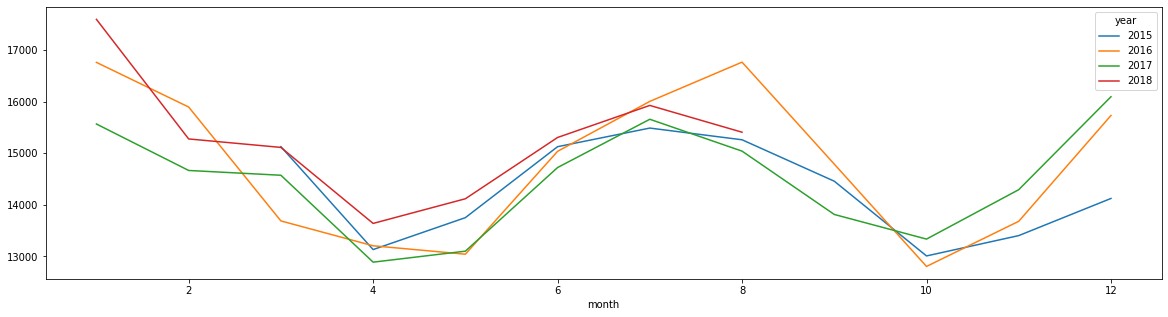

In [9]:
energy_consumption_pivot.plot()

##### 2. Тренд

Тренд можно извлечь с помощью скользящей средней по исходному временному ряду. 

$ MA =  \frac{1} {2m} \sum_{i=-1}^m (Y_{t+i}) $

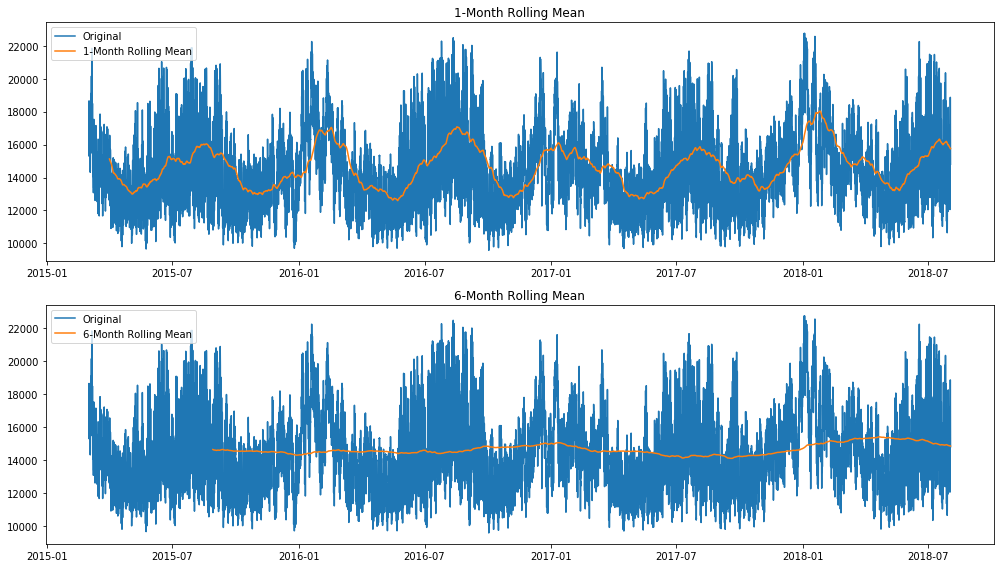

In [12]:
fig, axes = plt.subplots(2, 1, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

window = 24*30
axes[0].plot(energy_consumption.index, energy_consumption.AEP_MW, label='Original')
axes[0].plot(energy_consumption.index, energy_consumption.AEP_MW.rolling(window=window).mean(), label='1-Month Rolling Mean')
axes[0].set_title("1-Month Rolling Mean")
axes[0].legend(loc='best')

window = 24*30*6
axes[1].plot(energy_consumption.index, energy_consumption.AEP_MW, label='Original')
axes[1].plot(energy_consumption.index, energy_consumption.AEP_MW.rolling(window=window).mean(), label='6-Month Rolling Mean')
axes[1].set_title("6-Month Rolling Mean")
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

Чтобы извлечь тренд нужно использовать окно равное сезонности временного ряда (сезонность можно понять как визуально по графику, так и с помощью рядов Фурье - https://anomaly.io/detect-seasonality-using-fourier-transform-r/index.html).

##### 3. Остатки

То, что осталось после удаления сезонности и тренда, остаки должны напоминать белый шум.

**Декомпозиция временного ряда**

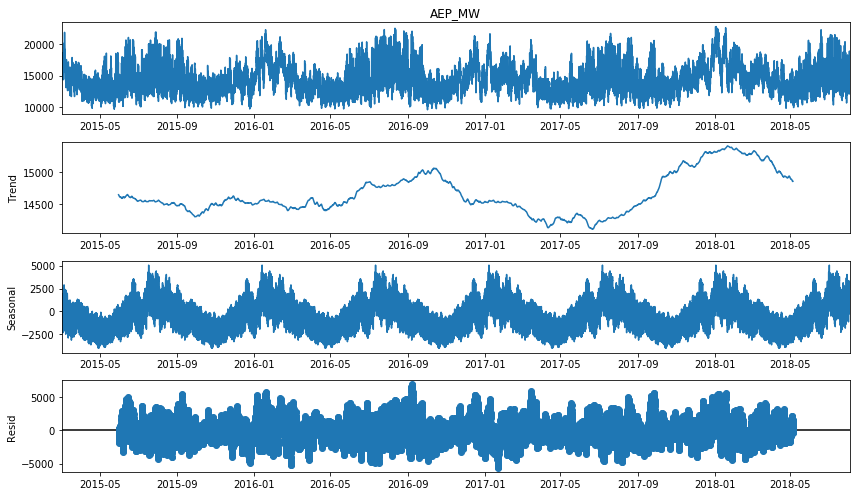

In [13]:
# STL-декомпозиция ряда
rcParams['figure.figsize'] = 12, 7
result = sm.tsa.seasonal_decompose(energy_consumption.AEP_MW, model='additive',freq= 24*30*6)
result.plot()
plt.show()

Модели, с помощью которых можно описать временной ряд.

<img width = '700px' src="images/lesson_10/methods.png">

Исходный временной ряд.

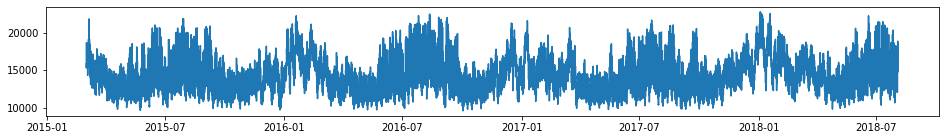

In [14]:
plt.figure(figsize=(16,2))

plt.plot(energy_consumption.AEP_MW)
plt.show()

Плавающее среднее.

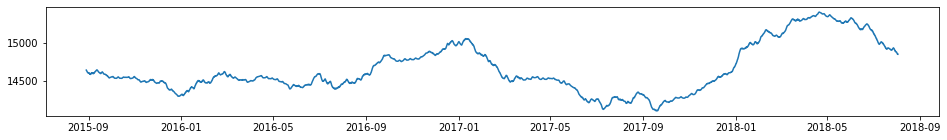

In [15]:
plt.figure(figsize=(16,2))

MA = energy_consumption.AEP_MW.rolling(window=24*30*6).mean()

plt.plot(MA)
plt.show()

Убираем тренд.

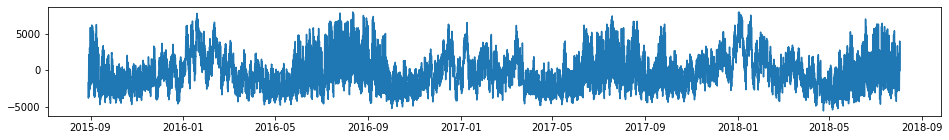

In [16]:
detrend_ = energy_consumption.AEP_MW - MA
# detrend_ = energy_consumption.AEP_MW / MA

plt.figure(figsize=(16,2))

plt.plot(detrend_)
plt.show()

Нормализуем по дням сезона

In [17]:
def seasonal_mean(x, period):
    """
    Return means for each period in x. period is an int that gives the
    number of periods per cycle. E.g., 12 for monthly. NaNs are ignored
    in the mean.
    """
    return np.array([pd_nanmean(x[i::period], axis=0) for i in range(period)])

In [18]:
s_a = seasonal_mean(detrend_, 24*30*6)
s_a -= np.mean(s_a, axis=0)

nobs = detrend_.shape[0]
seasonal = np.tile(s_a.T, nobs // 24*30*6 + 1).T[:nobs]

MemoryError: Unable to allocate 7.24 GiB for an array with shape (225001, 4320) and data type float64

In [ ]:
plt.figure(figsize=(16,2))

plt.plot(seasonal)
plt.show()

Остатки

In [253]:
residuals = energy_consumption.AEP_MW - MA - seasonal

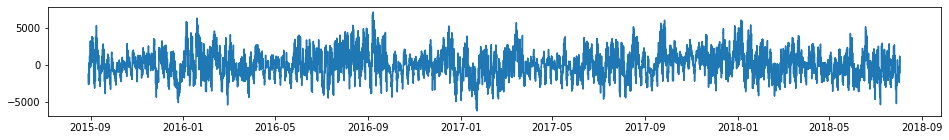

In [254]:
plt.figure(figsize=(16,2))

plt.plot(residuals)
plt.show()

### Предсказание по временному ряду

In [399]:
w_hours = 24
train = energy_consumption.iloc[:-w_hours]
val   = energy_consumption.iloc[-w_hours:]

**Задача** - предсказать потребление энергии на следующий день.

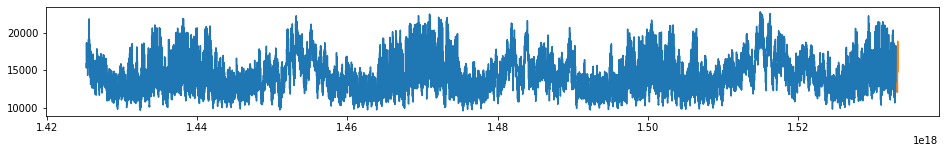

In [358]:
plt.figure(figsize=(16,2))

plt.plot(train.AEP_MW)
plt.plot(val.AEP_MW)

plt.show()

##### baseline

In [359]:
preds = [train.AEP_MW.mean()] * w_hours

In [366]:
#Будем вычислять RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
    
def rmse(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse

In [367]:
print('RMSE - ', rmse(val.AEP_MW, preds))

RMSE -  2542.1243340173924


In [368]:
# Относительная ошибка - хорошая метрика для бизнеса
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [371]:
print('MAPE - ', mean_absolute_percentage_error(val.AEP_MW,  preds))

MAPE -  13.881442128007624


##### Наивный подход

"Завтра = вчера"

${Y}_{t} =  Y_{t-n}$

In [1]:
preds = train.iloc[-w_hours:].AEP_MW.values

NameError: name 'train' is not defined

In [2]:
print('RMSE - ', rmse(val.AEP_MW, preds))
print('MAPE - ', mean_absolute_percentage_error(val.AEP_MW,  preds))

NameError: name 'rmse' is not defined

##### Предсказание плавающем средним

Новое значение будет вычисляться на основе среднего за конкретный период.

${Y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} Y_{t-n}$

In [375]:
#Оцениваем по последним N неделям
n = 10
tr_sample = train.iloc[-n*w_hours:]
preds_arr = np.array(tr_sample.AEP_MW).reshape(n,-1)

preds = preds_arr.mean(axis = 0)

In [376]:
print('RMSE - ', rmse(val.AEP_MW, preds))
print('MAPE - ', mean_absolute_percentage_error(val.AEP_MW,  preds))

RMSE -  430.80165099497935
MAPE -  2.261731940436


##### Взвешенное среднее

${Y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n Y_{t+1-n}$

In [377]:
W = np.array([0.001, 0.004, 0.005, 0.01 , 0.02 , 0.05 , 0.1  , 0.15 , 0.26 ,0.4])
preds_arr_W = np.array([preds_arr[x]*W[x] for x in range(len(W))])
preds = preds_arr_W.sum(axis = 0)

In [378]:
print('RMSE - ', rmse(val.AEP_MW, preds))
print('MAPE - ', mean_absolute_percentage_error(val.AEP_MW,  preds))

RMSE -  853.2407205091653
MAPE -  4.057324648476928


##### Экспоненциальное сглаживание


https://www.youtube.com/watch?v=Fqge2HDH2Co

Для прогноза будем учитывать все наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные.

${F}_{t} = \alpha \cdot Y_t + (1-\alpha) \cdot L_{t-1} $

In [379]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result[-1]

In [380]:
#Простой пример
series_val = [1,2,3,4,5,6]

result = [series_val[0]]

#alpha - насколько сильно мы не хотим помнить, что было в прошлом
# alpha = 0.9
alpha = 0.1

for n in range(1, len(series_val)):
#     print(series_val[n])
    result.append(alpha * series_val[n] + (1 - alpha) * result[n-1])
    
result   

[1, 1.1, 1.29, 1.561, 1.9049, 2.31441]

Попробуем интуитивно понять, что за этим стоит, раскроем скобки:

${F}_{t} = \alpha \cdot Y_t + L_{t-1}-\alpha L_{t-1} $

${F}_{t} = L_{t-1} + \alpha ( Y_t - L_{t-1}) $ -> ${F}_{t} = L_{t-1} + \alpha e_t $

То есть мы строим свой прогноз как бы учитывая ошибку, которую мы сделали на предыдущем шаге.

<img width = '500px' src="images/lesson_10/ses.png">

Две крайности:
- $ \alpha = 0$ -> прогноз - просто среднее

- $ \alpha = 1$ -> наивное предсказание

In [381]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [383]:
fit = SimpleExpSmoothing(np.asarray(energy_consumption.AEP_MW)).fit(smoothing_level=0.7,optimized=False)
fit.forecast(0)

array([15261.44014523])

##### Двойное экспоненциальное сглаживание

Подходит для работы с временными рядами, где есть устойчивый линейный тренд.

У нас есть следующие компоненты:

- линейное уравнение для построения прогноза    
${F}_{t} = {F}_{tT} + {F}_{tL}$    
- уравнение уровня    
${F}_{tL} = \alpha \cdot Y_t + (1-\alpha) \cdot (L_{t-1} + T_{t-1}) $
- уравнение тренда    
${F}_{tT} = \beta \cdot (L_t - L_{t-1}) + (1-\beta)T_{t-1} $

Итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

In [384]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result[-1]

In [385]:
double_exponential_smoothing(energy_consumption.AEP_MW, 0.4, 0.2)

15304.944514776882

In [386]:
fit = Holt(np.array(energy_consumption.AEP_MW)).fit(smoothing_level = 0.4,smoothing_slope = 0.2)
fit.forecast(2)[1]

15304.94451477688

##### Тройное экспоненциальное сглаживание

Учитывает в том числе и сезонность.

- уравнение тренда    
${F}_{tT} = \beta \cdot (L_t - L_{t-1}) + (1-\beta)T_{t-1} $

- уравнение уровня    
${F}_{tL} = \alpha \cdot Y_t/(S_{t-M}) + (1-\alpha) \cdot (L_{t-1} + T_{t-1}) $

- уравнение сезонности    
${F}_{tS} = \gamma \cdot Y_t/(L_t) + (1-\gamma) \cdot (S_{t-M}) $


Попробуем предсказать потребление энергии за последнюю неделю, отделим train и test.

In [387]:
fit1 = ExponentialSmoothing(np.asarray(train.AEP_MW) ,seasonal_periods=24 ,trend='add', seasonal='add',).fit()
forecast = pd.Series(fit1.forecast(len(val)))
forecast.index = val.index

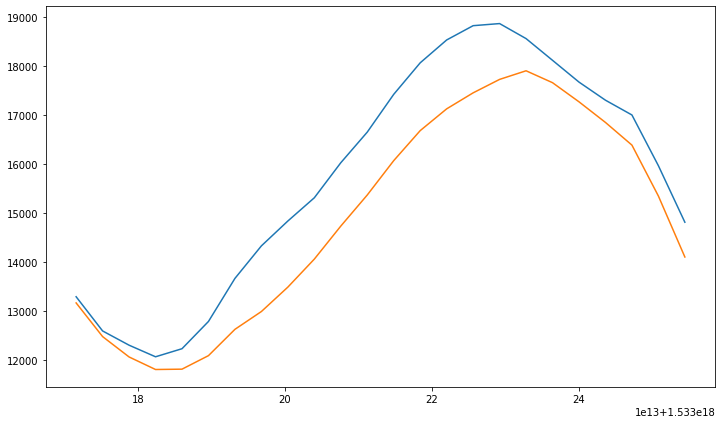

In [388]:
plt.plot(val.AEP_MW)
plt.plot(forecast)

### Валидация для временного ряда

В реальных задачах у нас нет возможности "заглянуть в будущее", поэтому наша валидация должна полностью повторять ситуацию на тесте.

<img width = '700px' src="images/lesson_10/validation.png">

In [398]:
from sklearn.model_selection import TimeSeriesSplit 
errors = []
    
tscv = TimeSeriesSplit(n_splits=4) 

for train_idx, test_idx in tscv.split(energy_consumption.AEP_MW):
    print('len_train - ', len(train_idx))
    print('len_test - ', len(test_idx))
    
    model = ExponentialSmoothing(np.asarray(energy_consumption.AEP_MW.iloc[train_idx]) ,seasonal_periods=24 , seasonal='add').fit()
    
    forecast = pd.Series(model.forecast(len(test_idx)))
    actual = energy_consumption.AEP_MW.iloc[test_idx]
    error = rmse(actual.values, forecast.values)
    errors.append(error)

len_train -  6000
len_test -  6000
len_train -  12000
len_test -  6000


C:\Users\k.izmailov\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\k.izmailov\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



len_train -  18000
len_test -  6000


C:\Users\k.izmailov\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



len_train -  24000
len_test -  6000


C:\Users\k.izmailov\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [400]:
errors

[2411.4443337003504, 2929.7612854874146, 2299.445904594735, 3769.2910693321546]

In [401]:
np.mean(errors)

2852.4856482786636

### Эконометрический подход

Перед тем как применять статистическую модель для временного ряда необходимо убедиться, что ряд стационарен.

**Стационарность** — свойство процесса не менять свои характеристики со временем. Временной ряд стаицонарен, если его свойства не зависят от времени.

- постоянство матожидания

<img width = '500px' src="images/lesson_10/stat1.png">

- постоянство дисперсии (она же гомоскедастичность)

<img width = '500px' src="images/lesson_10/stat2.png">

- независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями)

<img width = '500px' src="images/lesson_10/stat3.png">

Зачем?

- По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих.

Как определить стационарность?

- визуально изучить плавающее среднее, плавающее стандартное отклонеение

- применить статистический тест 

In [402]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 24, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [412]:
sample_data = train.AEP_MW[-1000:]

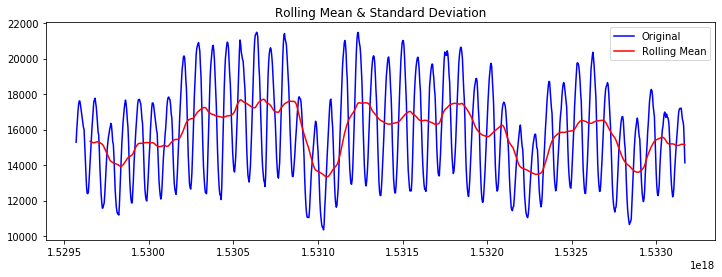

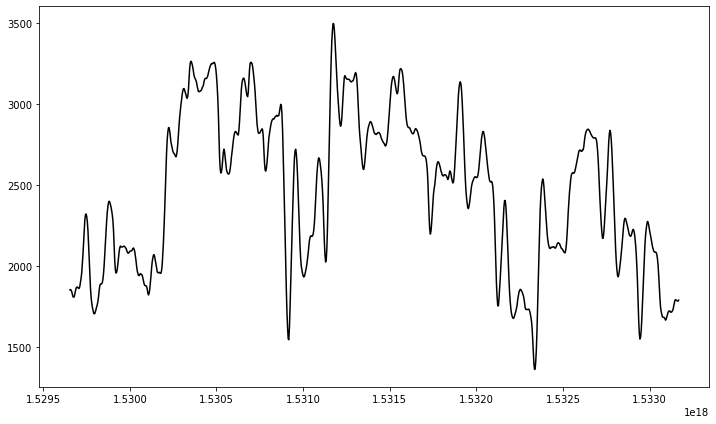

Results of Dickey-Fuller Test:
p-value = 0.1349. The series is likely non-stationary.
Test Statistic                  -2.424481
p-value                          0.134946
#Lags Used                      22.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


In [413]:
test_stationarity(sample_data)

Временной ряд **нестационарен**.

Подходы для того чтобы сделать временной ряд стационарным:
- в случае непостоянства дисперсии - логарифмирование либо преобразование Бокса-Кокса;
- почти всегда помогает дифференцирование (переход к попарным разностям ряда): стабилизирует среднее значение ряда, может применяться неоднократно, выделяют также сезонное дифференцирование - попарная разность по сезонам.

**Корреляция** (Пирсона) - сила линейной взаимосвязи между двумя случайными величинами.

Формула выборочной корреляции:
    
 $r_{X_1, X_2}  =\frac{ \sum_{i=1}^n (X_{1i} - \overline{X_1})(X_{2i} - \overline{X_2})}  {\sqrt{\sum_{i=1}^n (X_{1i} - \overline{X_1})^2\sum_{i=1}^n (X_{2i} - \overline{X_2})^2}} $   
 
 **Автокорреляция** (последовательная корреляция) - корреляция между последовательными показателями, упорядоченными во времени.

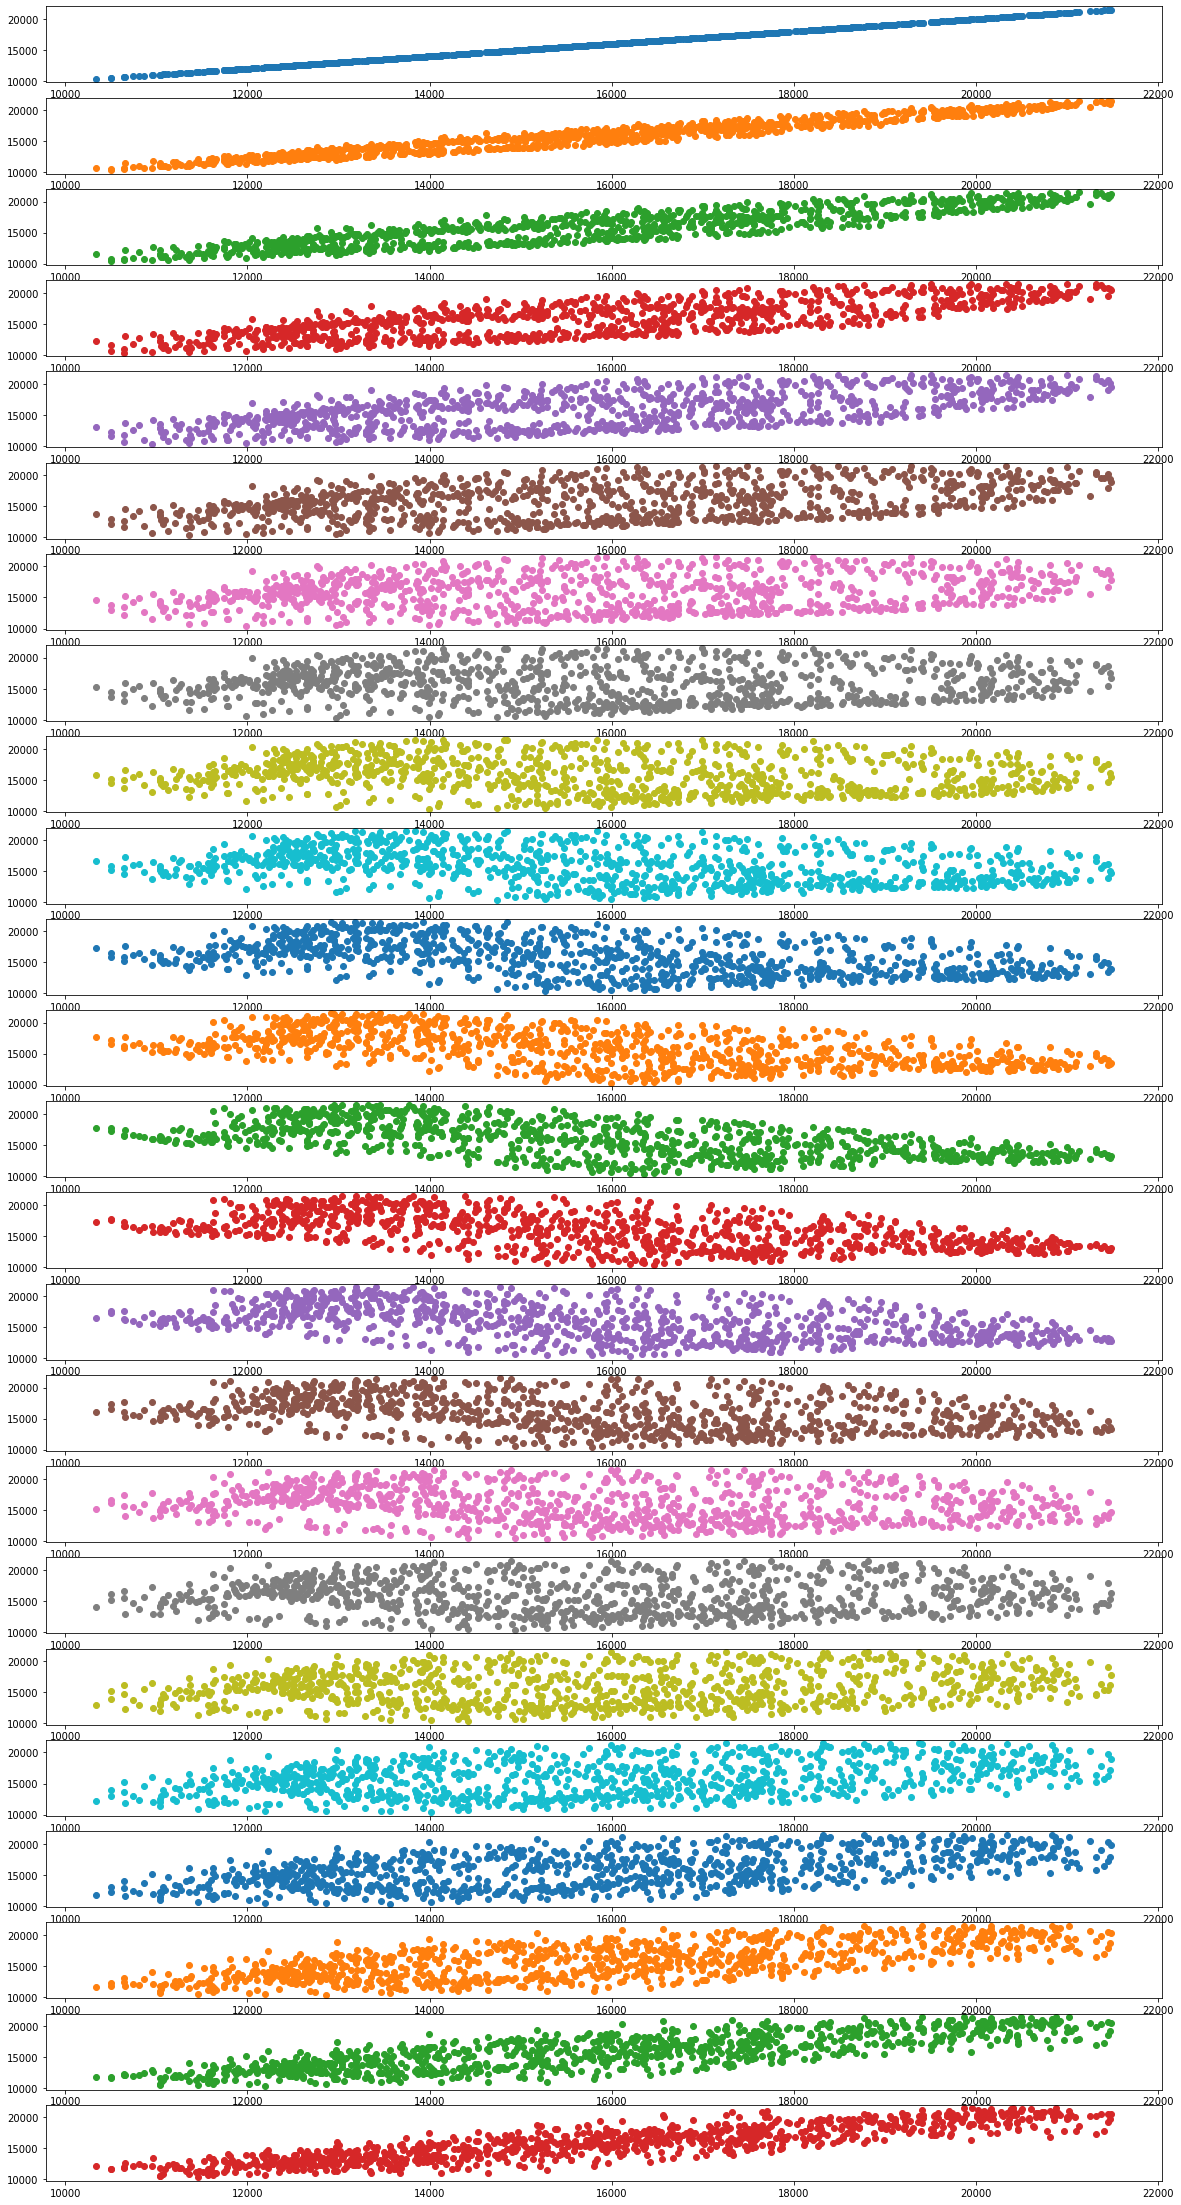

In [414]:
fig, axes = plt.subplots(24,1,figsize = (20,40))
for k, ax in enumerate(axes):
    for i in range(k):
        next(ax._get_lines.prop_cycler)
    ax.plot(sample_data,sample_data.shift(-k),'o')


plt.show()

Автокорреляция - корреляция между исходным рядом и его версией, который сдивнут на некий лаг **t** (лаг автокорреляции).

<img width = '500px' src="images/lesson_10/autocor.png">

### ARIMA

**ARIMA** - AR (Авторегрессия) + I(Интегрирование) + MA(Скользящее среднее). 

Будем строить модель SARIMA, модель, учитывающая сезонность ряда.

Чтобы построить модель нам нужно знать ее порядок, состоящий из 6-х параметров:

- p,P — порядок компоненты AR
- d,D — порядок интегрированного ряда
- q,Q — порядок компонетны MA

*Для p,P и q,Q надо изучить авторкорреляционную(ACF) и частную автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q и Q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA.
PACF поможет нам определить p и P, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.*

<img width = '700px' src="images/lesson_10/arima.png">

##### 1. Интегрирование

Необходимо избавиться от сезонности.

<img width = '600px' src="images/lesson_10/diff.png">

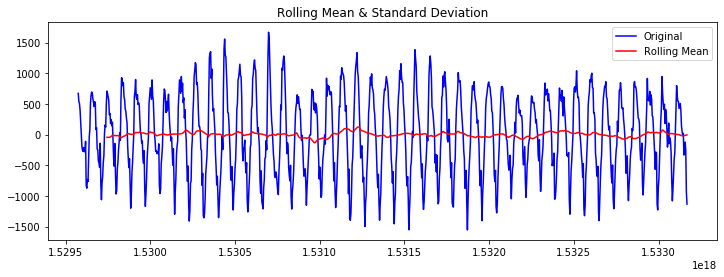

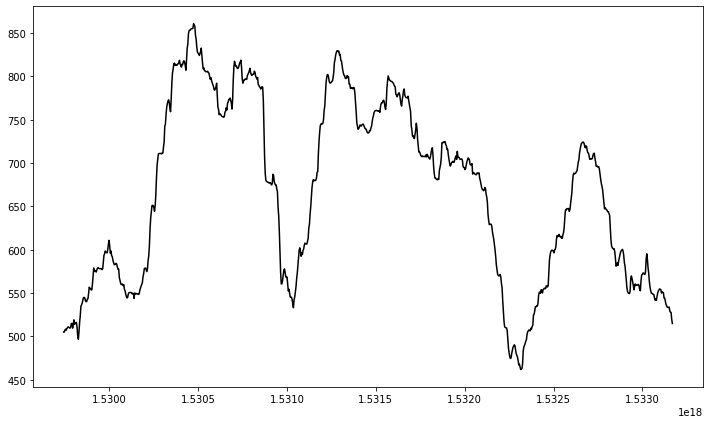

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -5.842911e+00
p-value                        3.741023e-07
#Lags Used                     2.200000e+01
Number of Observations Used    9.760000e+02
Critical Value (1%)           -3.437068e+00
Critical Value (5%)           -2.864506e+00
Critical Value (10%)          -2.568349e+00
dtype: float64


In [415]:
rcParams['figure.figsize'] = 12, 7
sample_data_diff = sample_data - sample_data.shift(1)
sample_data_diff.dropna(inplace = True)
test_stationarity(sample_data_diff, window = 48)

**Компонент d = 1, D = 0, так как сезонное дифференцирование мы не делали.**

Все же, если ряд сезонный, то рекомендуется начинать именно с сезонного дифференцирования (D).

##### 2. Авторегрессия (AR - компонент)

Надо понять влияние прошлых периодов на текущий период.

<img width = '500px' src="images/lesson_10/auto.png">

Модель - линейная комбинация **p** предыдущих значений ряда, шумовой компоненты и константы.

Чтобы определить параметр p (найти его приближение), необходимо обратиться к Частной АвтоКорреляционной Функции.

**Частичная автокорреляционная функция** показывает корреляцию между двумя случайными переменными за вычетом влияния всех внутренних значений автокорреляции. 

<img width = '400px' src="images/lesson_10/partial_autocor.png">

Автокорреляция показывает зависимость между y4 и y1, при этом игнорируя эффект от изменения y2 и y3. А частная автокорреляция также показывает эффект между y4 и y1, при этом учитывая, что эффект от y2 и y3 отсутсвует, то есть убирает эффекты y2 и y3.

Рекомендации к подбору первоначальных приближений:

P(p) - номер последнего сезонного (несезонного) лага, при котором частная автокорреляция значима (персекается граница доверительного интервала), при этом стоит учитывать, что большое число компонентов ведет к увеличению сложности модели и переобучению, если Р > 0, то p не может быть больше сезонного лага.

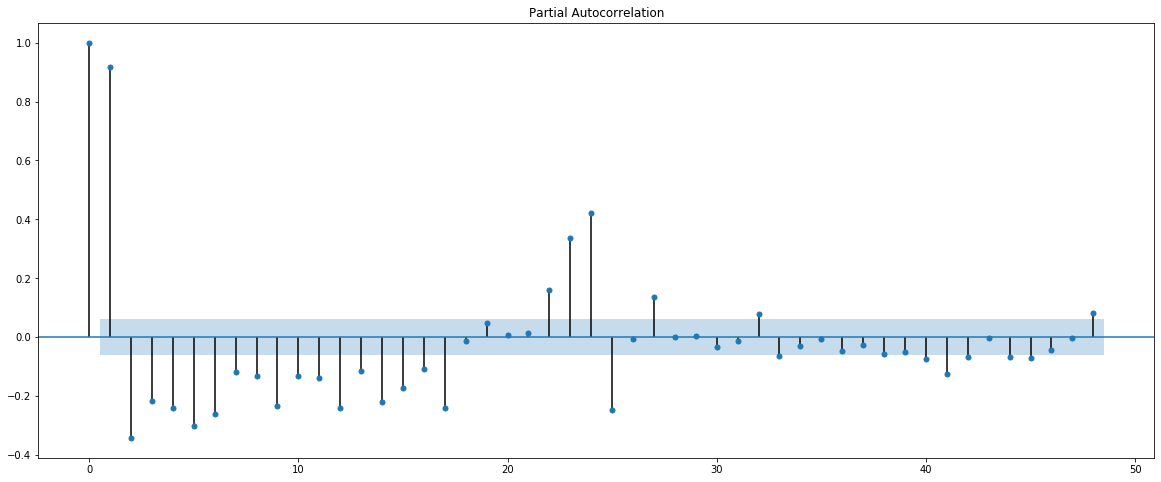

In [416]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_pacf(sample_data_diff.values, lags=48,ax = ax)
plt.show()

##### 3. Скользящее среднее (MA - компонент)

Будем строить модель, как линейную комбинацию **q** последних значений шумовой компоненты. Модель, где используется зависимость между наблюдением и остаточными ошибками от скользящей средней модели применительно к запаздывающим наблюдениям.

<img width = '500px' src="images/lesson_10/ma.png">

Q(q) - номер последнего сезонного (несезонного) лага, при котором автокорреляция значима, если Q > 0, то q не может быть больше сезонного лага.

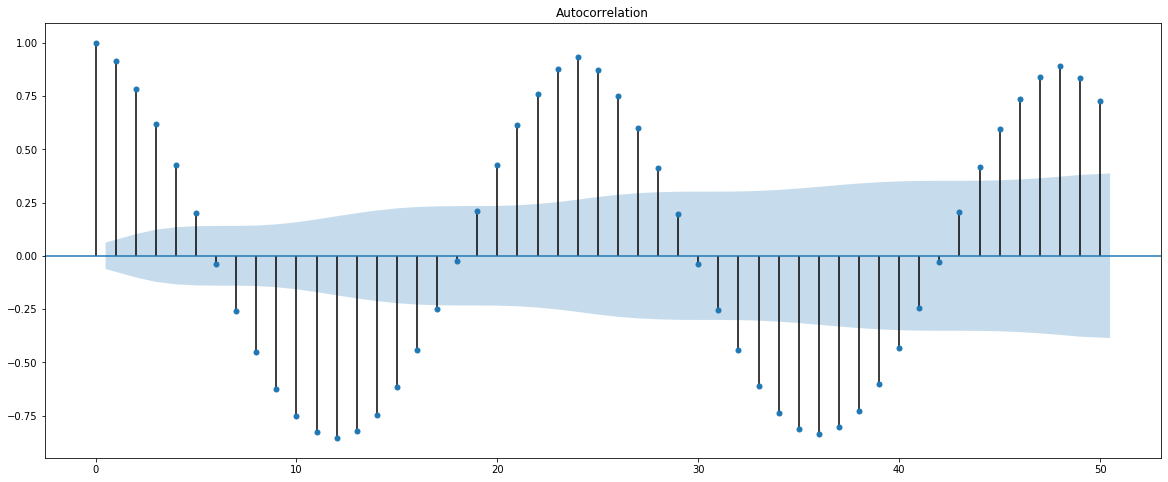

In [417]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_acf(sample_data_diff.values, lags=50,ax = ax)
plt.show()

##### 4. Построение прогноза

In [418]:
d = 1
D = 0
s = 24

ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=0
Qs = range(0, 2)

In [419]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [420]:
%%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(sample_data, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 9.35 s


In [421]:
print(best_model.summary().tables[0])
print(best_model.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                             AEP_MW   No. Observations:                 1000
Model:             SARIMAX(1, 1, 0)x(1, 0, 1, 12)   Log Likelihood               -6603.251
Date:                            Sat, 18 Apr 2020   AIC                          13214.502
Time:                                    15:04:03   BIC                          13234.129
Sample:                                06-21-2018   HQIC                         13221.962
                                     - 08-02-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6818      0.022     31.637      0.000       0.640       0.724
ar.S.L12      -0.9974      0.001   

Изучим остатки модели, действительно ли они представляют белый шум.

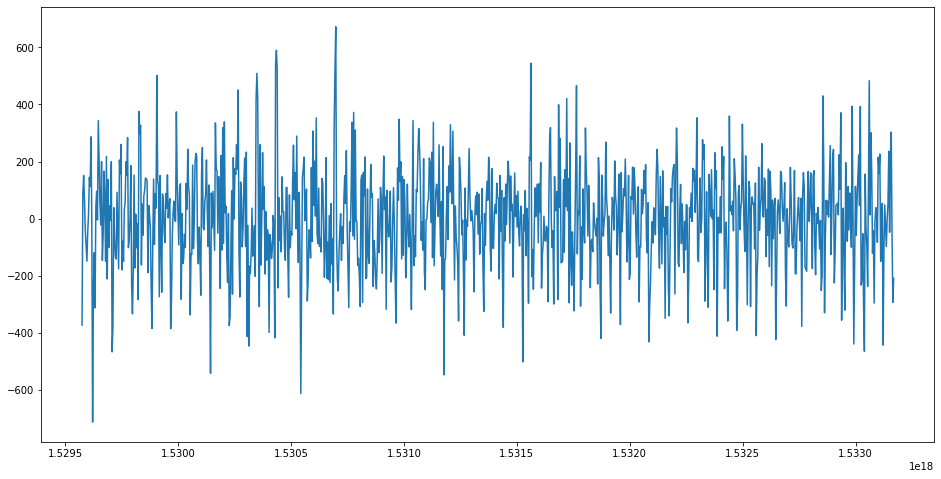

In [422]:
# Остатки модели
plt.figure(figsize=(16,8))
plt.plot(best_model.resid[1:])
plt.show()

In [423]:
stat_test = sm.tsa.adfuller(best_model.resid[:])
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -11.886202481605546
p-value:  6.0153980972332185e-22
Critical values:  {'1%': -3.4370471695043037, '5%': -2.8644967585264784, '10%': -2.5683443301882956}
единичных корней нет, ряд стационарен


In [434]:
forecast = best_model.predict(start = sample_data.shape[0], end = sample_data.shape[0]+23)

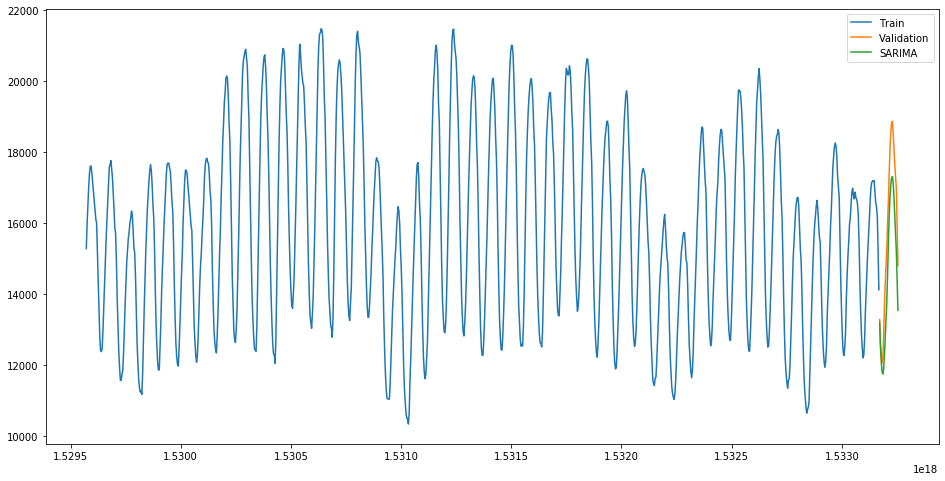

In [435]:
plt.figure(figsize=(16,8))
plt.plot(sample_data, label='Train')
plt.plot(val.AEP_MW, label='Validation')
plt.plot(forecast, label='SARIMA')
plt.legend(loc='best')
plt.show()

In [437]:
print('RMSE - ', rmse(val.AEP_MW, forecast))
print('MAPE - ', mean_absolute_percentage_error(val.AEP_MW,  forecast))

RMSE -  1284.7676958027134
MAPE -  7.2163758131145075


### Линейные модели

Иногда проще всего будет просто построить линейную модель, включив туда фичи, основанные на времени:
    - лаговые фичи
    - статистики по лаговым фичам
    - час, день, минута
    - праздники, выходные
    - и т.д.

In [438]:
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

In [447]:
train['label'] = 'train'
val['label'] = 'val'

df = pd.concat((train,val), axis = 0)
df['target'] = np.where(df.label == 'train', df.AEP_MW, np.nan)
df.head(2)

C:\Users\k.izmailov\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\k.izmailov\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AEP_MW,year,month,dow,hour,label,target
Datetime,,,,,,,
2015-03-02 00:00:00,15867.0,2015,3,0,0,train,15867.0
2015-03-02 01:00:00,15444.0,2015,3,0,1,train,15444.0


In [456]:
# лаговые фичи
lag_period = 24
features = []
for period_mult in range(1,10,1):
    df["lag_period_{}".format(period_mult)] = df.target.shift(period_mult*lag_period)
    features.append("lag_period_{}".format(period_mult))

# # лаговые статистики
df['lagf_mean'] = df[features].mean(axis = 1)

features.extend(['lagf_mean'])

In [458]:
df.tail(2)

,AEP_MW,year,month,dow,hour,label,target,lag_period_1,lag_period_2,lag_period_3,lag_period_4,lag_period_5,lag_period_6,lag_period_7,lag_period_8,lag_period_9,lagf_mean
Datetime,,,,,,,,,,,,,,,,,
2018-08-02 23:00:00,15964.0,2018,8,3,23,val,NaN,15259.0,15504.0,15592.0,14665.0,14094.0,15095.0,16530.0,16349.0,16225.0,15479.222222
2018-08-03 00:00:00,14809.0,2018,8,4,0,val,NaN,14125.0,14424.0,14363.0,13680.0,13017.0,13885.0,15127.0,15027.0,14927.0,14286.111111


In [465]:
model = LinearRegression()
train_df = df[df.label == 'train'][features + ['target']].dropna()
test_df = df[df.label == 'val'][features]

model.fit(train_df.drop('target', axis = 1) ,train_df['target'])
forecast = model.predict(test_df)

In [470]:
test_df['prediction'] = forecast

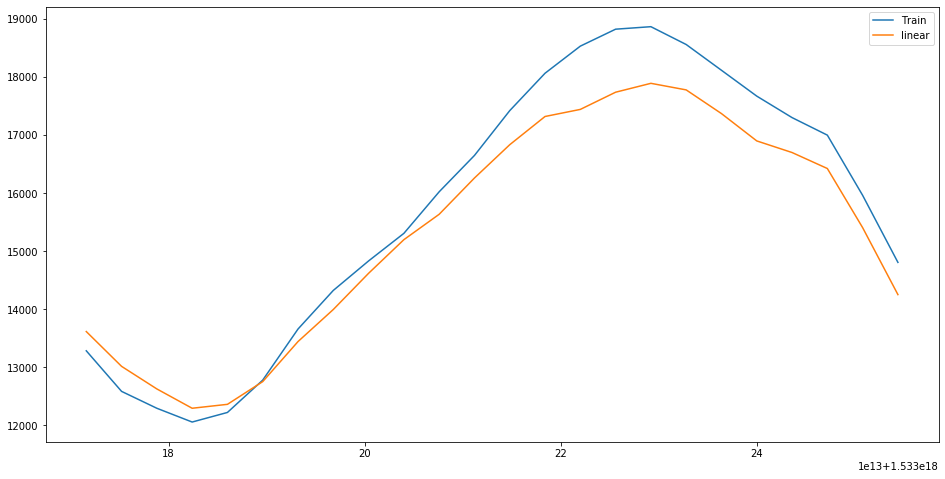

In [473]:
plt.figure(figsize=(16,8))
plt.plot(val.AEP_MW, label='Train')
plt.plot(test_df.prediction, label='linear')
plt.legend(loc='best')
plt.show()

In [474]:
print('RMSE - ', rmse(val.AEP_MW, test_df.prediction))
print('MAPE - ', mean_absolute_percentage_error(val.AEP_MW,  test_df.prediction))

RMSE -  587.6185982069749
MAPE -  3.075524776994427


In [467]:
def plotCoefficients(model,train_features):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, train_features)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

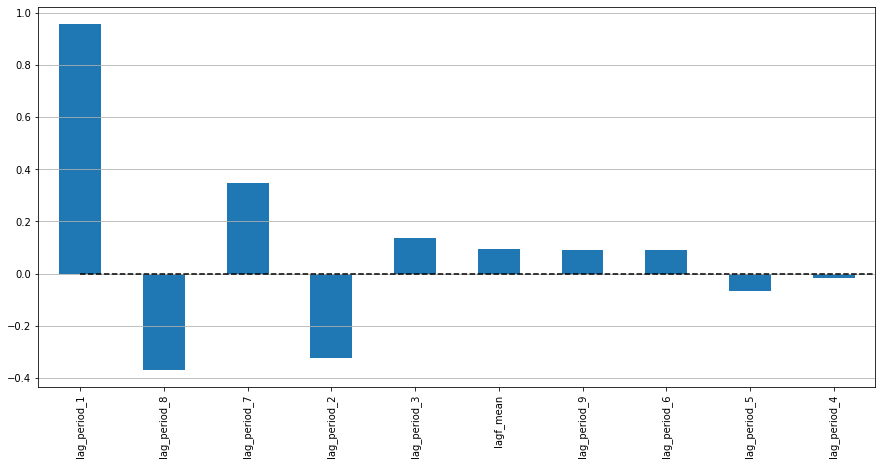

In [468]:
plotCoefficients(model,features)

### Prophet

In [476]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

In [477]:
train.head()

,AEP_MW,year,month,dow,hour,label
Datetime,,,,,,
2015-03-02 00:00:00,15867.0,2015,3,0,0,train
2015-03-02 01:00:00,15444.0,2015,3,0,1,train
2015-03-02 02:00:00,15307.0,2015,3,0,2,train
2015-03-02 03:00:00,15328.0,2015,3,0,3,train
2015-03-02 04:00:00,15373.0,2015,3,0,4,train


In [481]:
train_dataset= pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(train.index)
train_dataset['y']  = train.AEP_MW.values
train_dataset.head(2)

,ds,y
0,2015-03-02 00:00:00,15867.0
1,2015-03-02 01:00:00,15444.0


In [482]:
prophet_basic = Prophet()
prophet_basic.fit(train_dataset)

In [493]:
future= prophet_basic.make_future_dataframe(periods= 24, freq = 'H')
future.tail(2)

,ds
29998,2018-08-02 23:00:00
29999,2018-08-03 00:00:00


In [494]:
forecast=prophet_basic.predict(future)

In [497]:
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-03-02 00:00:00,15689.306473,12431.465522,16361.705450,15689.306473,15689.306473,-1265.451640,-1265.451640,-1265.451640,-821.173381,...,-440.532385,-440.532385,-440.532385,-3.745873,-3.745873,-3.745873,0.0,0.0,0.0,14423.854833
1,2015-03-02 01:00:00,15688.445360,11796.169128,15847.540833,15688.445360,15688.445360,-1890.886673,-1890.886673,-1890.886673,-1513.726761,...,-372.030445,-372.030445,-372.030445,-5.129467,-5.129467,-5.129467,0.0,0.0,0.0,13797.558687


In [507]:
preds = forecast['yhat'].iloc[-24:]
preds.index = val.index

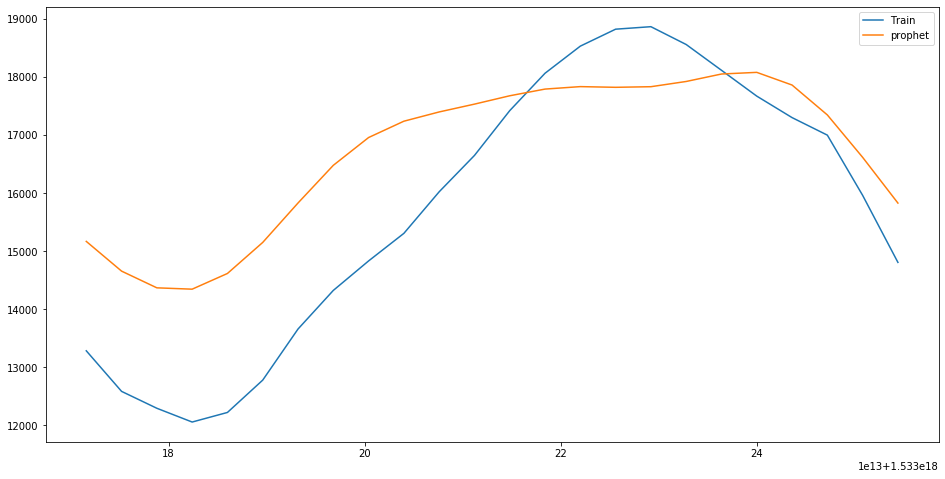

In [509]:
plt.figure(figsize=(16,8))
plt.plot(val.AEP_MW, label='Train')
plt.plot(preds, label='prophet')
plt.legend(loc='best')
plt.show()

In [510]:
print('RMSE - ', rmse(val.AEP_MW, forecast['yhat'].iloc[-24:].values))
print('MAPE - ', mean_absolute_percentage_error(val.AEP_MW,  forecast['yhat'].iloc[-24:].values))

RMSE -  1502.8260922975046
MAPE -  9.0139876031103
